# 07 — Model evaluation & external images

Questo notebook serve per:
- caricare **un modello salvato** dalla cartella `models/`
- valutarlo su **test set** (dal DB)
- (opzionale) valutarlo su **immagini esterne** in `data/external/<classe>/...`

Nota: usa i moduli in `src/garbagecls/` (`db.py`, `paths.py`, `dataset.py`).

In [14]:
# === Imports & setup ===
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

# --- Make sure we can import src/garbagecls ---
PROJECT_ROOT = Path.cwd().parent  # notebook is in /notebooks
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in os.sys.path:
    os.sys.path.insert(0, str(SRC_DIR))

from garbagecls.db import read_images_df, split_dfs  # uses db.py
from garbagecls.dataset import make_dataset          # uses dataset.py
from garbagecls.paths import abs_path



## 1) Carico i metadati dal DB e preparo i DataFrame (train/val/test)
Qui non addestriamo nulla: ci serve solo `df_test` (e `label2id/id2label`) per la valutazione coerente.

In [15]:
# === Load metadata from DB and prepare DataFrames (train/val/test + external) ===
SEED = 42
BATCH_SIZE = 32

# main dataset (source='raw_flat'): it already contains the split column populated in notebook 01
df_all = read_images_df(source="raw_flat")
df_train, df_val, df_test = split_dfs(df_all)

print("Rows:", len(df_all), "| train:", len(df_train), "| val:", len(df_val), "| test:", len(df_test))
print("Classes:", sorted(df_train["label"].unique().tolist()),'\n')

# Build stable label <-> id mapping from TRAIN only (no leakage)
labels_sorted = sorted(df_train["label"].unique().tolist())
label2id = {lab: i for i, lab in enumerate(labels_sorted)}
id2label = {i: lab for lab, i in label2id.items()}

def add_label_id(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["label_id"] = df["label"].map(label2id)
    missing = df["label_id"].isna()
    if missing.any():
        bad = sorted(df.loc[missing, "label"].unique().tolist())
        raise ValueError(
            f"Found labels not present in training label2id: {bad}. "
            f"Check folder names / DB labels."
        )
    df["label_id"] = df["label_id"].astype("int32")
    return df

df_train = add_label_id(df_train)
df_val   = add_label_id(df_val)
df_test  = add_label_id(df_test)

# external dataset (if you populated it in DB with source='external')
df_external = read_images_df(source="external")
if df_external is not None and len(df_external) > 0:
    df_external = add_label_id(df_external)
    print("External rows (from DB):", len(df_external))
else:
    print("External rows (from DB): 0  -> you can still use filesystem fallback below (optional).")


Rows: 2527 | train: 1768 | val: 379 | test: 380
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] 

External rows (from DB): 28


c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)
c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


## 2) Selezione modello da `models/`
Scegli il file copiando il nome e incollandolo in `MODEL_FILE`.

In [16]:
# === Choose model to evaluate (copy-paste filename) ===
MODELS_DIR = PROJECT_ROOT / "models"
if not MODELS_DIR.exists():
    raise FileNotFoundError(f"Cartella models non trovata: {MODELS_DIR}")

#stampa la lista dei modelli disponibili
print("Available models in models/:")
for p in sorted(MODELS_DIR.glob("*.keras")):
    print(" -", p.name)

# Copy/paste the exact filename from models/ (example below)
MODEL_FILE = "cnn_transfer_mnv2_head_best_2026-0205-1354.keras"  # <-- change me

MODEL_PATH = MODELS_DIR / MODEL_FILE
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Modello non trovato: {MODEL_PATH}")

print('\n',"Chosen model:", MODEL_PATH.name)


Available models in models/:
 - cnn_baseline_2026-0205-144944.keras
 - cnn_baseline_best.keras
 - cnn_transfer_mnv2_finetune_best_2026-0205-1354.keras
 - cnn_transfer_mnv2_head_best_2026-0205-1354.keras
 - logistic_regression_20260203-195326.keras

 Chosen model: cnn_transfer_mnv2_head_best_2026-0205-1354.keras


## 3) Carico il modello e ricavo `IMG_SIZE`
Per evitare mismatch, prendiamo (H,W) da `model.input_shape`.

In [17]:
# === Load model ===
model = keras.models.load_model(MODEL_PATH)

# Se il modello è stato salvato senza stato di compilazione (capita), lo compiliamo al volo per evaluate()
if model.optimizer is None:
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

model.summary()

# Ricaviamo IMG_SIZE direttamente dall'input del modello (coerente con come è stato addestrato)
inp = model.input_shape  # (None, H, W, 3)
IMG_SIZE = (inp[1], inp[2]) if (isinstance(inp, (tuple, list)) and len(inp) >= 3 and inp[1] and inp[2]) else (224, 224)
print("IMG_SIZE from model:", IMG_SIZE)


Model: "mnv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281,044 (8.70 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 15,374 (60.06 KB)

IMG_SIZE from model: (192, 256)


## 4) Creo i dataset `val` e `test` (no augmentation)

In [18]:
# === Build tf.data datasets for evaluation (no augmentation) ===
# NOTE: IMG_SIZE is set after loading the chosen model (derived from model input_shape)

val_ds = make_dataset(df_val,   training=False, batch_size=BATCH_SIZE, seed=SEED, img_size=IMG_SIZE, augment=False)
test_ds = make_dataset(df_test, training=False, batch_size=BATCH_SIZE, seed=SEED, img_size=IMG_SIZE, augment=False)

external_ds = None
if 'df_external' in globals() and (df_external is not None) and (len(df_external) > 0):
    external_ds = make_dataset(df_external, training=False, batch_size=BATCH_SIZE, seed=SEED, img_size=IMG_SIZE, augment=False)

val_ds, test_ds, external_ds


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

Verifico file obsoleti nel database, eventualmente devo eseguire populate per pulirli

In [19]:
for p in df_external["filepath"].head(50):
    if not Path(str(abs_path(p))).exists():
        print("MISSING:", p)


## 5) Valutazione su `test` + report + confusion matrix


=== MAIN TEST Classification report ===
              precision    recall  f1-score   support

   cardboard     0.8548    0.8833    0.8689        60
       glass     0.7875    0.8289    0.8077        76
       metal     0.7260    0.8548    0.7852        62
       paper     0.8778    0.8876    0.8827        89
     plastic     0.8413    0.7260    0.7794        73
       trash     0.9167    0.5500    0.6875        20

    accuracy                         0.8211       380
   macro avg     0.8340    0.7885    0.8019       380
weighted avg     0.8264    0.8211    0.8195       380



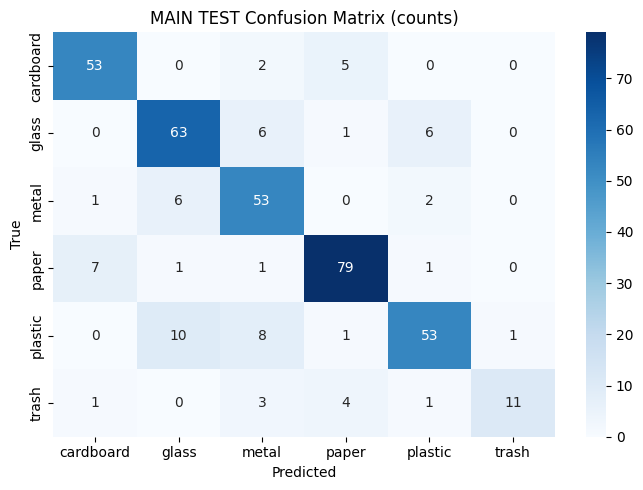

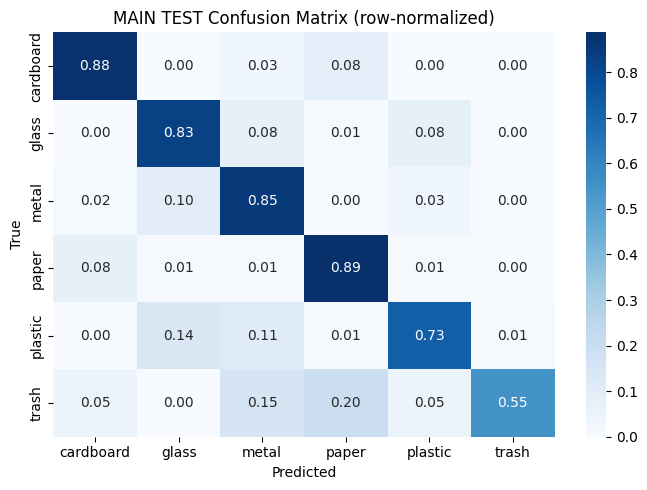


=== EXTERNAL Classification report ===
              precision    recall  f1-score   support

   cardboard     0.5556    0.7143    0.6250         7
       glass     0.6667    0.4000    0.5000         5
       metal     0.5000    1.0000    0.6667         2
       paper     0.2500    0.5000    0.3333         2
     plastic     0.5000    0.1818    0.2667        11
       trash     0.0000    0.0000    0.0000         1

    accuracy                         0.4286        28
   macro avg     0.4120    0.4660    0.3986        28
weighted avg     0.5079    0.4286    0.4217        28



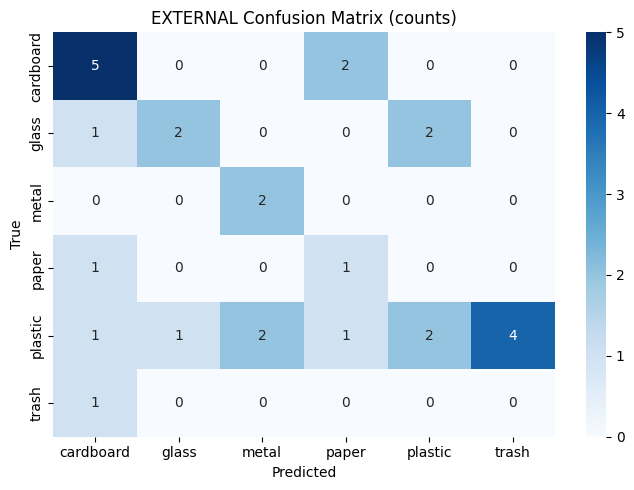

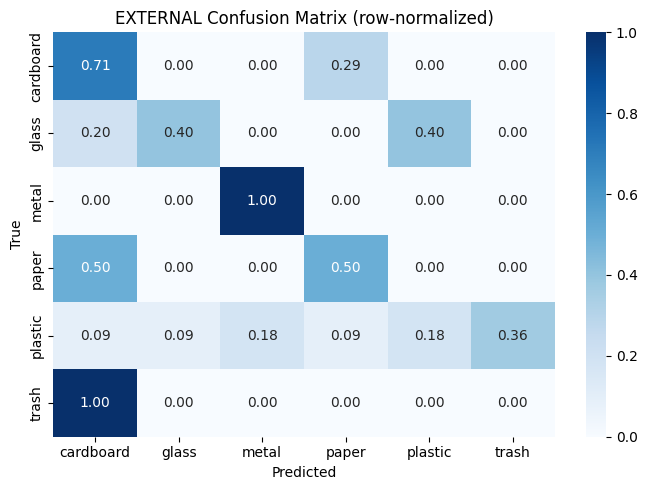

In [20]:
# === Evaluation: metrics + confusion matrix (main test + external) ===
from sklearn.metrics import confusion_matrix, classification_report

def _predict_on_dataset(model, ds):
    # Returns y_true, y_pred, y_prob (softmax). Works with batched tf.data.
    y_true, y_pred, y_prob = [], [], []
    for x_batch, y_batch in ds:
        probs = model.predict(x_batch, verbose=0)  # (B, C)
        preds = np.argmax(probs, axis=1)
        y_true.extend(y_batch.numpy().tolist())
        y_pred.extend(preds.tolist())
        y_prob.extend(probs.tolist())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

def eval_and_report(model, ds, id2label, title_prefix=""):
    y_true, y_pred, y_prob = _predict_on_dataset(model, ds)

    target_names = [id2label[i] for i in range(len(id2label))]
    print(f"\n=== {title_prefix} Classification report ===")
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    # Confusion matrix: counts
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(id2label))))
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f"{title_prefix} Confusion Matrix (counts)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Confusion matrix: row-normalized (recall per class on diagonal)
    cm_norm = cm.astype("float") / np.maximum(cm.sum(axis=1, keepdims=True), 1)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", cbar=True,
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f"{title_prefix} Confusion Matrix (row-normalized)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Table for later "best/worst examples"
    df_pred = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "true_label": [id2label[int(i)] for i in y_true],
        "pred_label": [id2label[int(i)] for i in y_pred],
        "pred_conf": y_prob.max(axis=1),
    })
    return df_pred

# 1) Main TEST set (source='raw_flat' + split='test')
df_pred_test = eval_and_report(model, test_ds, id2label, title_prefix="MAIN TEST")

# 2) External set (source='external') -> only if present
df_pred_external = None
if external_ds is not None:
    df_pred_external = eval_and_report(model, external_ds, id2label, title_prefix="EXTERNAL")
else:
    print("\n(No external images in DB: source='external' returned 0 rows)")


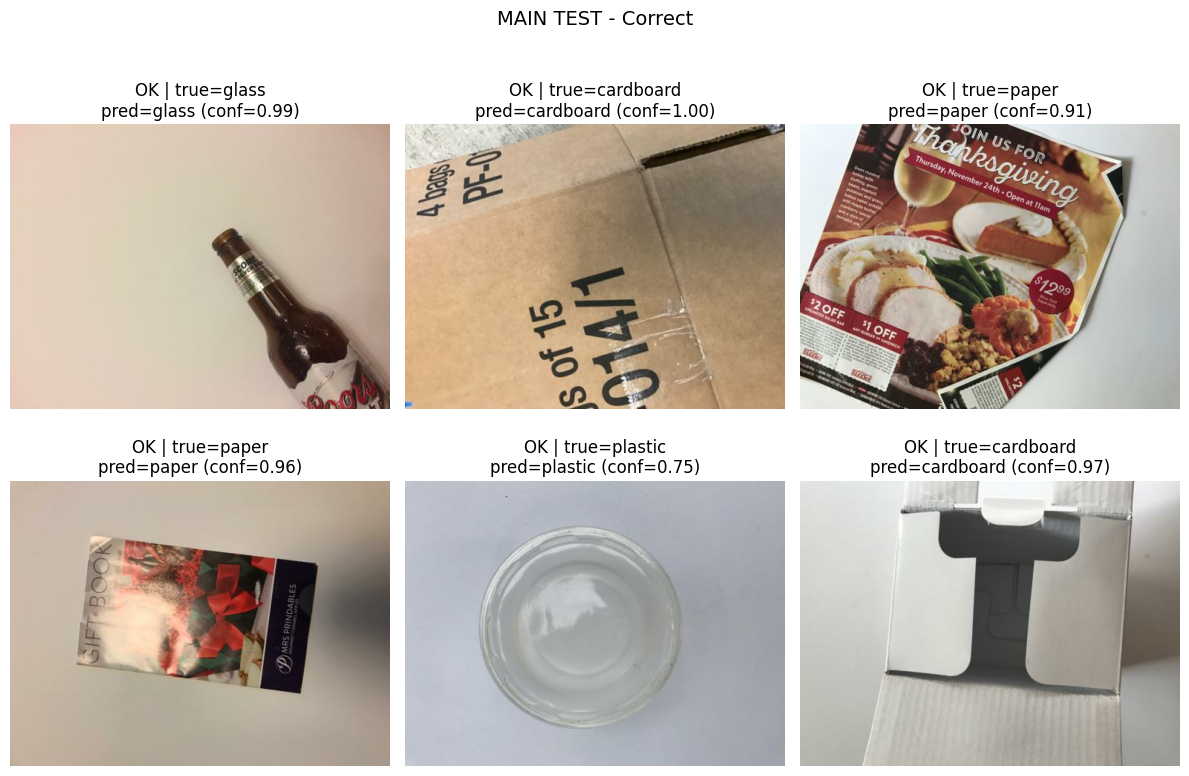

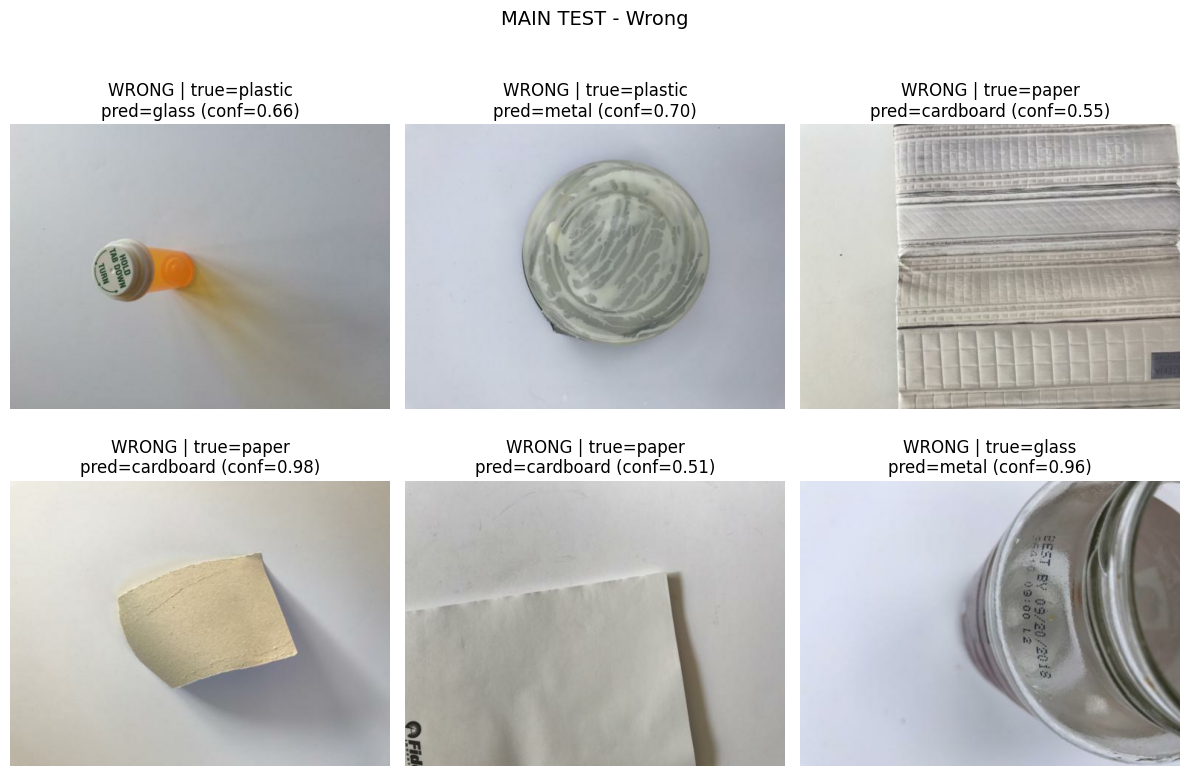

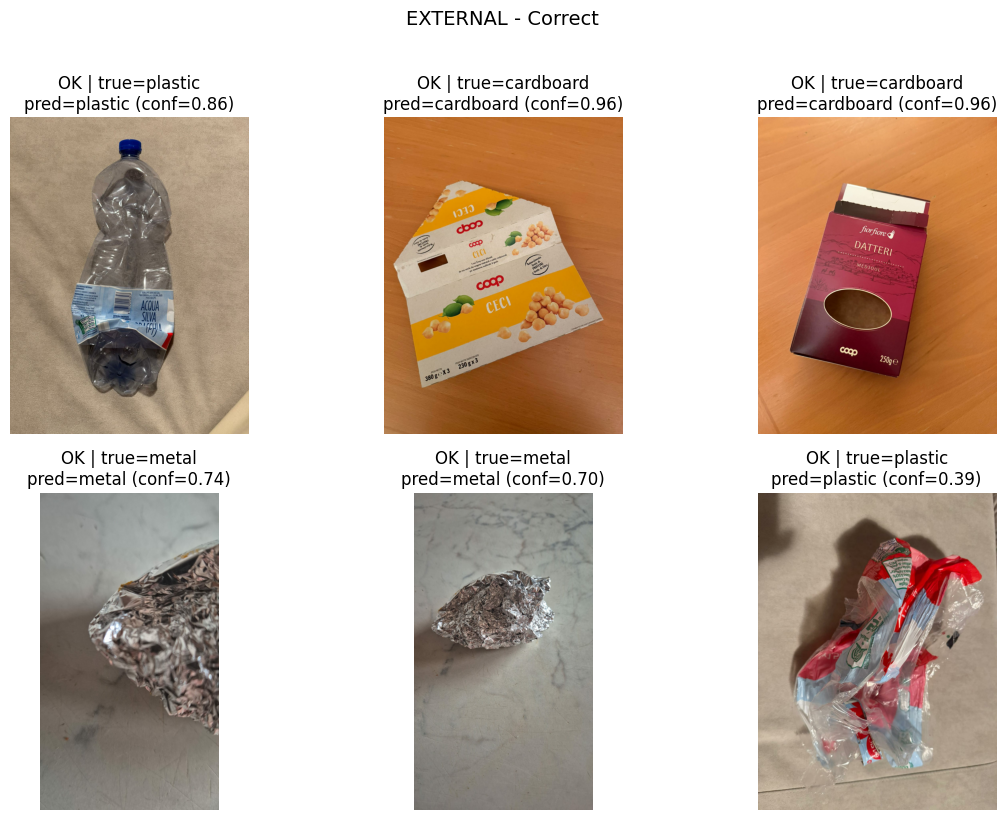

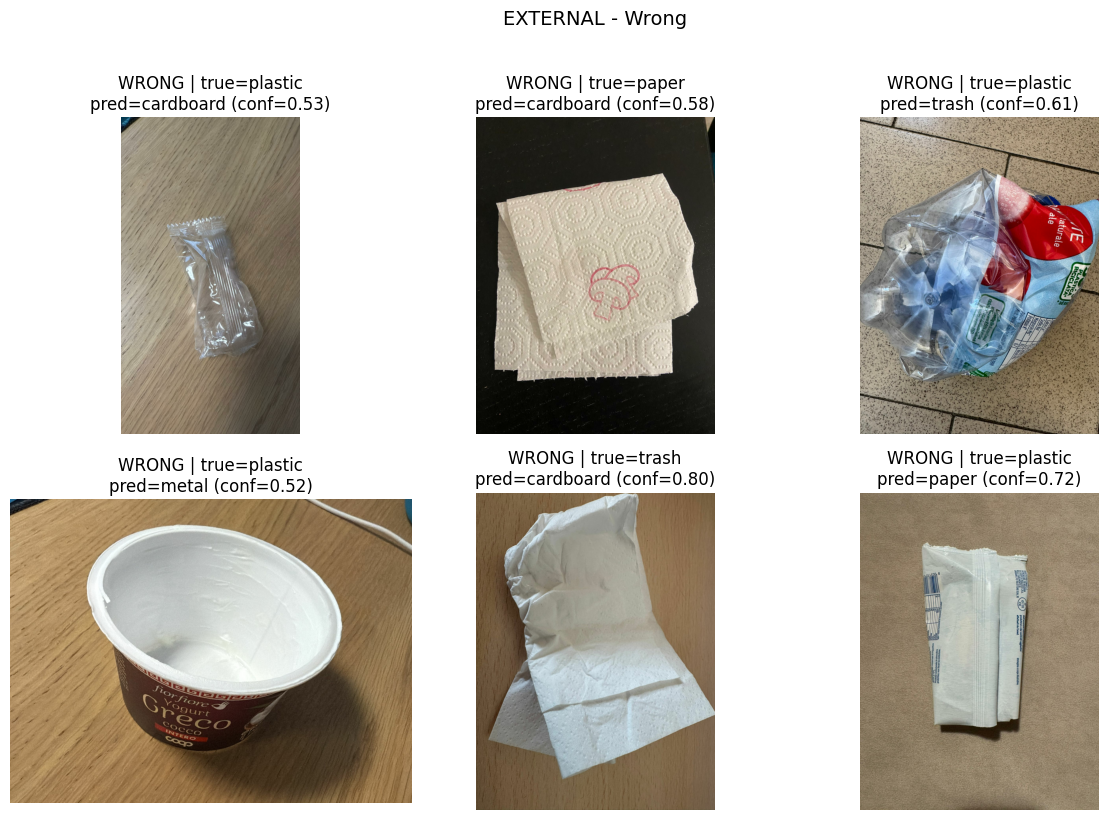

In [21]:
# === Visual inspection: some correct vs wrong predictions (main test + external) ===
import random
import matplotlib.pyplot as plt
import tensorflow as tf

def _show_examples(df_meta, df_pred, title, n=6, correct=True, seed=42):
    rng = random.Random(seed)
    df_meta = df_meta.reset_index(drop=True)
    df_pred = df_pred.reset_index(drop=True)
    df_res = pd.concat([df_meta, df_pred], axis=1)

    mask = (df_res["y_true"] == df_res["y_pred"]) if correct else (df_res["y_true"] != df_res["y_pred"])
    subset = df_res.loc[mask].copy()

    if len(subset) == 0:
        print(f"{title}: no examples for correct={correct}")
        return

    # pick n random rows
    idxs = rng.sample(list(subset.index), k=min(n, len(subset)))
    subset = subset.loc[idxs]

    cols = 3
    rows = int(np.ceil(len(subset) / cols))
    plt.figure(figsize=(12, 4 * rows))
    for i, (_, r) in enumerate(subset.iterrows(), start=1):
        path = str(abs_path(r["filepath"]))
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)

        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        ok = "OK" if r["y_true"] == r["y_pred"] else "WRONG"
        plt.title(f"{ok} | true={r['true_label']}\npred={r['pred_label']} (conf={r['pred_conf']:.2f})")
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# MAIN TEST examples
_show_examples(df_test, df_pred_test, title="MAIN TEST - Correct", n=6, correct=True, seed=SEED)
_show_examples(df_test, df_pred_test, title="MAIN TEST - Wrong",   n=6, correct=False, seed=SEED)

# EXTERNAL examples (if present)
if df_pred_external is not None:
    _show_examples(df_external, df_pred_external, title="EXTERNAL - Correct", n=6, correct=True, seed=SEED)
    _show_examples(df_external, df_pred_external, title="EXTERNAL - Wrong",   n=6, correct=False, seed=SEED)


## 6) Note
- Questo notebook ti permette di confrontare rapidamente modelli diversi: cambia solo `MODEL_FILE`.
- Se vuoi salvare un riepilogo: scrivi `test_metrics` / `ext_metrics` in un JSON (come fai negli altri notebook).